# PREVENDO O RISCO DE INADIMPLÊNCIA NO CRÉDITO RESIDENCIAL

### FEATURE ENGINEERING

#### Udacity - Engenheiro de Machine Learning
Vinicius Ferreira Santos - vyniciuss@gmail.com

## HOME CREDIT


### Importando as bibliotecas

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
#Classes utilitárias
from helper import *
from PipelineBuilder import *
import warnings
warnings.filterwarnings("ignore")
import gc
import pickle

C:\Users\vynic\Anaconda3\envs\py36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
#carregando os dados de treinamento
data_train = pd.read_csv("data/application_train.csv")
train_ids = data_train['SK_ID_CURR']
train_labels = data_train['TARGET']
features_train = data_train.drop(columns = ['SK_ID_CURR', 'TARGET'])
#carregando os dados de teste
data_test = pd.read_csv("data/application_test.csv")
test_ids = data_train['SK_ID_CURR']
features_test = data_train.drop(columns = ['SK_ID_CURR'])


# Sucesso - Exibindo o primeiro registro treino
display(features_train.head(n=1))

# Sucesso - Exibindo o primeiro registro teste
display(features_test.head(n=1))

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## Preparar os dados



### Fixar ou remover outliers

In [3]:
num_attribs = nomes_atributos_numericos(features_train)
numeric_features_train = features_train[num_attribs].fillna(0)

def remove_outliers(df_numeric, df):
    for feature in df_numeric.keys():
        # Calcula Q1 (25º percentil dos dados)
        Q1 = np.percentile(df_numeric[feature], 25)
        # Calcula Q3 (75º percentil dos dados) 
        Q3 = np.percentile(df_numeric[feature], 75)
        # Utiliza a amplitude interquartil para calcular o valor discrepante (1,5 vezes a variação interquartil)
        step = (Q3 - Q1) * 1.5
        #print("Dados considerados discrepantes para a feature '{}':".format(feature))
        #display(numeric_features[~((numeric_features[feature] >= Q1 - step) & (numeric_features[feature] <= Q3 + step))])
        index = df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index      
        df.loc[df.index[index], feature] = np.nan

In [4]:
remove_outliers(numeric_features_train, features_train)

### Visualizando dados ausentes

In [369]:
missing_features = missing_values(features_train)
missing_features

,Total de Ausentes,Percentual de Ausentes
COMMONAREA_MODE,283157,92.1
COMMONAREA_MEDI,279032,90.7
COMMONAREA_AVG,278654,90.6
FLOORSMIN_MEDI,274450,89.2
FLOORSMIN_AVG,274249,89.2
FLOORSMIN_MODE,273922,89.1
NONLIVINGAPARTMENTS_AVG,252962,82.3
NONLIVINGAPARTMENTS_MEDI,251414,81.8
NONLIVINGAPARTMENTS_MODE,248256,80.7
NONLIVINGAREA_MEDI,246557,80.2


### Preencher valores ausentes(com média, zero...) ou removê-los.


Antes de iniciar a criação das features, preciso resolver um problema dectado na análise exploratória e aumentado com a remoção dos outliers, referente a grande quantidade de dados ausentes. Para o classificador não entender que a ausência de dados é um padrão interessante, irei remover as features que apresentarem mais que 50% de dados ausentes. Para as features numéricas que apresentarem menos que 50% de dados ausentes, será imputada a mediana, a fim de evitar problemas provenientes das distorções nas distribuições.

In [21]:
features_train = features_train.loc[:, features_train.isnull().mean() < .5]
#Alinhando as colunas de teste com as de treinamento
features_train, features_test = features_train.align(features_test, join = 'inner', axis = 1)
display(features_train.head())
display(features_test.head())

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Foram removidas 45 features

In [6]:
def transformando_e_criando_features(df):
    # recuperando nome das features categóricas
    cat_attribs = nomes_atributos_categoricos(df)
    # converte as colunas object em str
    df[cat_attribs] = df[cat_attribs].astype(str)
    # removendo dado inválido que representa mais de mil anos de emprego
    #df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
    # variáveis financeiras tem uma distribuição log-normal
    df['AMT_INCOME_TOTAL_LOG'] = np.log(df['AMT_INCOME_TOTAL'])
    df['AMT_CREDIT_LOG'] = np.log(df['AMT_CREDIT'])
    df['AMT_ANNUITY_LOG'] = np.log(df['AMT_ANNUITY'])
    #criando colunas e transformando datas em dias para anos
    df['AGE'] = (abs(df['DAYS_BIRTH']) / 365).astype(np.int64)
    df['YEAR_EMPLOYED'] = (abs(df['DAYS_EMPLOYED']) / 365).fillna(0).astype(np.int64)
    df['YEAR_REGISTRATION'] = (abs(df['DAYS_REGISTRATION']) / 365).fillna(0).astype(np.int64)


In [7]:
transformando_e_criando_features(features_train)    
transformando_e_criando_features(features_test)  
cat_attribs = nomes_atributos_categoricos(features_train)    
num_attribs = nomes_atributos_numericos(features_train)
numeric_features = features_train[num_attribs]
gc.collect()
#Alinhando as colunas de teste com as de treinamento
features_train, features_test = features_train.align(features_test, join = 'inner', axis = 1)
display(features_train.head())
display(features_test.head())

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_INCOME_TOTAL_LOG,AMT_CREDIT_LOG,AMT_ANNUITY_LOG,AGE,YEAR_EMPLOYED,YEAR_REGISTRATION
0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.0,0.0,0.0,1.0,12.218495,12.915579,10.114579,25,1,9
1,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0.0,0.0,0.0,0.0,12.506177,14.072864,10.482864,45,3,3
2,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,11.119883,11.813030,8.817298,52,0,11
3,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,11.813030,12.652944,10.298448,52,8,26
4,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,11.707670,13.148031,9.992665,54,8,11


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_INCOME_TOTAL_LOG,AMT_CREDIT_LOG,AMT_ANNUITY_LOG,AGE,YEAR_EMPLOYED,YEAR_REGISTRATION
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.0,0.0,0.0,1.0,12.218495,12.915579,10.114579,25,1,9
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0.0,0.0,0.0,0.0,12.506177,14.072864,10.482864,45,3,3
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,11.119883,11.813030,8.817298,52,0,11
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,11.813030,12.652944,10.298448,52,8,26
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,11.707670,13.148031,9.992665,54,8,11


### Combinando features numéricas

In [8]:
combined_features = {'CREDIT_PER_INCOME': [numeric_features.columns.get_loc('AMT_CREDIT'), 
                                           numeric_features.columns.get_loc('AMT_INCOME_TOTAL')],
                     
                     'CREDIT_PER_MEMBER': [numeric_features.columns.get_loc('AMT_CREDIT'),
                                           numeric_features.columns.get_loc('CNT_FAM_MEMBERS')],
                     
                     'AMT_CREDIT_PER_ANNUITY': [numeric_features.columns.get_loc('AMT_CREDIT'),
                                                numeric_features.columns.get_loc('AMT_ANNUITY')],
                     
                     'ANNUITY_PER_INCOME': [numeric_features.columns.get_loc('AMT_ANNUITY'),
                                                numeric_features.columns.get_loc('AMT_INCOME_TOTAL')], 
                     
                     'AMT_INCOME_TOTAL_PER_AGE': [numeric_features.columns.get_loc('AMT_INCOME_TOTAL'),
                                                numeric_features.columns.get_loc('AGE')],
                     
                     'AMT_INCOME_TOTAL_PER_MEMBER': [numeric_features.columns.get_loc('AMT_INCOME_TOTAL'),
                                                numeric_features.columns.get_loc('CNT_FAM_MEMBERS')],                    
                     
                     'AMT_CREDIT_PER_AGE': [numeric_features.columns.get_loc('AMT_CREDIT'),
                                               numeric_features.columns.get_loc('AGE')]
                     }


pipelineBuilder = PipelineBuilder()
num_pipeline = pipelineBuilder.build_numeric_pipeline(num_attribs, combined_features = combined_features)

data_attr_combinados = num_pipeline.fit_transform(features_train)
print(data_attr_combinados.shape)

data_attr_combinados = pd.DataFrame(
    data_attr_combinados,
    columns=list(features_train[num_attribs].columns)+num_pipeline.named_steps['attribs_adder'].name_combined_features)
data_attr_combinados.head()

(307511, 75)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,AGE,YEAR_EMPLOYED,YEAR_REGISTRATION,CREDIT_PER_INCOME,CREDIT_PER_MEMBER,AMT_CREDIT_PER_ANNUITY,ANNUITY_PER_INCOME,AMT_INCOME_TOTAL_PER_AGE,AMT_INCOME_TOTAL_PER_MEMBER,AMT_CREDIT_PER_AGE
0,-0.583687,0.783762,-0.464117,-0.098525,-0.473290,-0.055568,1.506880,0.894907,0.377004,0.579154,...,-1.542169,-0.638831,-0.426451,-0.759873,0.411059,-0.631046,-0.670129,2.139332,2.226755,0.248804
1,-0.583687,1.860901,2.076659,0.811798,2.272661,-1.470514,-0.166821,0.477951,1.084713,1.790855,...,0.130831,-0.153635,-1.055053,0.289873,1.442870,1.767268,-0.560548,1.080988,0.940904,1.593940
2,-0.583687,-1.370514,-1.242180,-1.584320,-1.235172,-0.868652,-0.689509,1.206678,0.201083,0.306869,...,0.716381,-0.881429,-0.216917,-0.762848,-0.755850,-0.201804,-0.905345,-1.288654,-0.344948,-1.224282
3,-0.583687,-0.293376,-0.733162,0.314175,-0.663760,-1.055302,-0.680114,-0.922751,-1.400892,0.369143,...,0.716381,1.059355,1.354588,-0.643585,-0.664158,-1.350102,0.377881,-0.634458,-0.344948,-0.856007
4,-0.583687,-0.508804,-0.159299,-0.333183,0.098122,0.858862,-0.892535,-0.921994,0.186423,-0.307263,...,0.883681,1.059355,-0.216917,0.075414,0.868213,0.218064,-0.049544,-0.808911,0.683733,-0.480197


### Criando features polinomiais

In [9]:
name_poly_features = ['AMT_CREDIT_POLY','AMT_INCOME_TOTAL_POLY','DAYS_BIRTH_POLY',
                       'EXT_SOURCE_2_POLY', 'EXT_SOURCE_3_POLY']
index_poly_features = [features_train.columns.get_loc('AMT_CREDIT'), 
                       features_train.columns.get_loc('AMT_INCOME_TOTAL'),
                       features_train.columns.get_loc('DAYS_BIRTH'),
                       features_train.columns.get_loc('EXT_SOURCE_2'),
                       features_train.columns.get_loc('EXT_SOURCE_3')]

poly_features = {'POLY_FEATURES': [name_poly_features, index_poly_features]} 

pipelineBuilder = PipelineBuilder()
num_pipeline = pipelineBuilder.build_numeric_pipeline(num_attribs, poly_features = poly_features)

data_attr_combinados = num_pipeline.fit_transform(features_train)
print(data_attr_combinados.shape)
data_attr_combinados = pd.DataFrame(
    data_attr_combinados,
    columns=list(features_train[num_attribs].columns)+num_pipeline.named_steps['attribs_adder'].name_created_poly_features)
data_attr_combinados.head()


(307511, 124)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,DAYS_BIRTH_POLY^3,DAYS_BIRTH_POLY^2 EXT_SOURCE_2_POLY,DAYS_BIRTH_POLY^2 EXT_SOURCE_3_POLY,DAYS_BIRTH_POLY EXT_SOURCE_2_POLY^2,DAYS_BIRTH_POLY EXT_SOURCE_2_POLY EXT_SOURCE_3_POLY,DAYS_BIRTH_POLY EXT_SOURCE_3_POLY^2,EXT_SOURCE_2_POLY^3,EXT_SOURCE_2_POLY^2 EXT_SOURCE_3_POLY,EXT_SOURCE_2_POLY EXT_SOURCE_3_POLY^2,EXT_SOURCE_3_POLY^3
0,-0.583687,0.783762,-0.464117,-0.098525,-0.473290,-0.055568,1.506880,0.894907,0.377004,0.579154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.583687,1.860901,2.076659,0.811798,2.272661,-1.470514,-0.166821,0.477951,1.084713,1.790855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.583687,-1.370514,-1.242180,-1.584320,-1.235172,-0.868652,-0.689509,1.206678,0.201083,0.306869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.583687,-0.293376,-0.733162,0.314175,-0.663760,-1.055302,-0.680114,-0.922751,-1.400892,0.369143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.583687,-0.508804,-0.159299,-0.333183,0.098122,0.858862,-0.892535,-0.921994,0.186423,-0.307263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### OneHotEncoder para features categóricas


In [10]:
pipelineBuilder = PipelineBuilder()
cat_pipeline = pipelineBuilder.build_cat_pipeline(cat_attribs)
data_attr_combinados = cat_pipeline.fit_transform(features_train)
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
attributes = []
for itens, feature in zip(cat_encoder.categories_, cat_attribs):
    for item in itens:
        attributes.append('{}_{}'.format(feature, item))        
        
data_attr_combinados = pd.DataFrame(data_attr_combinados, columns= attributes)
data_attr_combinados.head()        

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Transformando os dados

In [11]:
pipelineBuilder = PipelineBuilder()
full_pipeline = pipelineBuilder.build_full_pipeline(cat_attribs, num_attribs,
                                                                  poly_features=poly_features, 
                                                                   combined_features = combined_features)
#transformando as features de treinamento
features_attr_combinados_train = full_pipeline.fit_transform(features_train)
#transformando as features de teste
#features_attr_combinados_train = full_pipeline.transform(features_teste)
#recuperando os nomes das features polinomias criadas
poly_names = full_pipeline.transformer_list[0][1].named_steps['attribs_adder'].name_created_poly_features
#recuperando os nomes das features combinadas criadas
combined_names = full_pipeline.transformer_list[0][1].named_steps['attribs_adder'].name_combined_features
#recuperando os nomes das features categóricas após onehotencoding
cat_encoder = full_pipeline.transformer_list[1][1].named_steps["cat_encoder"]
cat_names = []
for itens, feature in zip(cat_encoder.categories_, cat_attribs):
    for item in itens:
        cat_names.append('{}_{}'.format(feature, item)) 
#refazendo o dataframe com os nomes das features
data_attr_combinados_train = pd.DataFrame(
    features_attr_combinados_train,
    columns=list(features_train[num_attribs].columns)+poly_names
                + combined_names
                + cat_names)


data_attr_combinados_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,-0.583687,0.783762,-0.464117,-0.098525,-0.473290,-0.055568,1.506880,0.894907,0.377004,0.579154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.583687,1.860901,2.076659,0.811798,2.272661,-1.470514,-0.166821,0.477951,1.084713,1.790855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.583687,-1.370514,-1.242180,-1.584320,-1.235172,-0.868652,-0.689509,1.206678,0.201083,0.306869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.583687,-0.293376,-0.733162,0.314175,-0.663760,-1.055302,-0.680114,-0.922751,-1.400892,0.369143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.583687,-0.508804,-0.159299,-0.333183,0.098122,0.858862,-0.892535,-0.921994,0.186423,-0.307263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
#utilizando o imputer treinado para preencher os dados de test
imputer = full_pipeline.transformer_list[0][1].named_steps['imputer']
features_test[num_attribs] = imputer.transform(features_test[num_attribs])
features_test[num_attribs].head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_INCOME_TOTAL_LOG,AMT_CREDIT_LOG,AMT_ANNUITY_LOG,AGE,YEAR_EMPLOYED,YEAR_REGISTRATION
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,1.0,12.218495,12.915579,10.114579,25.0,1.0,9.0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,0.0,0.0,0.0,12.506177,14.072864,10.482864,45.0,3.0,3.0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,0.0,0.0,0.0,0.0,11.119883,11.813030,8.817298,52.0,0.0,11.0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,0.0,0.0,0.0,1.0,11.813030,12.652944,10.298448,52.0,8.0,26.0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,0.0,0.0,0.0,0.0,11.707670,13.148031,9.992665,54.0,8.0,11.0


In [13]:
full_pipeline = pipelineBuilder.build_full_pipeline(cat_attribs, num_attribs,
                                                                  poly_features=poly_features, 
                                                                   combined_features = combined_features)

features_attr_combinados_test = full_pipeline.fit_transform(features_test)
#refazendo o dataframe com os nomes das features
data_attr_combinados_test = pd.DataFrame(
    features_attr_combinados_test,
    columns=list(features_test[num_attribs].columns)
                +poly_names
                + combined_names
                + cat_names)

data_attr_combinados_test.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,-0.577538,0.142129,-0.478095,-0.166142,-0.507236,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.577538,0.426792,1.725450,0.592684,1.600873,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.577538,-0.427196,-1.152888,-1.404668,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.577538,-0.142533,-0.711430,0.177875,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.577538,-0.199466,-0.213734,-0.361748,-0.068554,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Separando em dados treino e teste

In [277]:
x_train, x_test, y_train, y_test = train_test_split(data_attr_combinados, train_labels,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=train_labels)

### Realizando redução de dimensionalidade

Nesta seção, irei utilizar a análise de componentes principais (PCA), a fim reduzir o número de features que, após as transformações necessárias, pulou de 75 para 260. Outro objetivo do PCA é a possibilidade de descobrir qual dimensão dos dados melhor maximizam a variância das features.

Para descobrir o número ideal de dimensões, irei realizar uma pesquisa do melhor ajuste com o GridSearch utilizando uma randomforest.

In [245]:
pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1))
])

n_dimensoes = [2, 4, 8, 10, 15, 20, 30]
param_grid = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': n_dimensoes
    }
]

grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=param_grid, scoring='roc_auc')
grid.fit(x_train, y_train)
mean_scores = np.array(grid.cv_results_['mean_test_score'])

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.9s finished
[Parall

### Visualizando a acurácia por dimensão

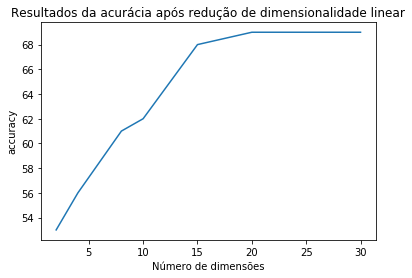

O número de dimensões ideal é 30 com uma accuracy de 69.0%


,Accuracy
Acurácia com 2 dimensões,53.0
Acurácia com 4 dimensões,56.0
Acurácia com 8 dimensões,61.0
Acurácia com 10 dimensões,62.0
Acurácia com 15 dimensões,68.0
Acurácia com 20 dimensões,69.0
Acurácia com 30 dimensões,69.0


In [255]:
plt.figure()
plt.title("Resultados da acurácia após redução de dimensionalidade linear")
plt.xlabel("Número de dimensões")
plt.ylabel("accuracy")
plt.plot(n_dimensoes, np.round(mean_scores, 2) * 100)
plt.show()
pca = grid.best_estimator_.named_steps['reduce_dim']
print('O número de dimensões ideal é {} com uma accuracy de {}%'.format(len(pca.components_), max(np.round(mean_scores, 2)* 100)))
mean_scores2 = pd.DataFrame(np.round(mean_scores, 2)* 100, columns = ['Accuracy'])
mean_scores2.index = ['Acurácia com {} dimensões'.format(i) for i in n_dimensoes] 
display(mean_scores2)

Como podemos perceber na visualização acima, o gridSearch identificou que o número ideal de dimensões é 30, conseguindo atingir uma acurácia de 65%.

### Visualizando a variação das dimensões

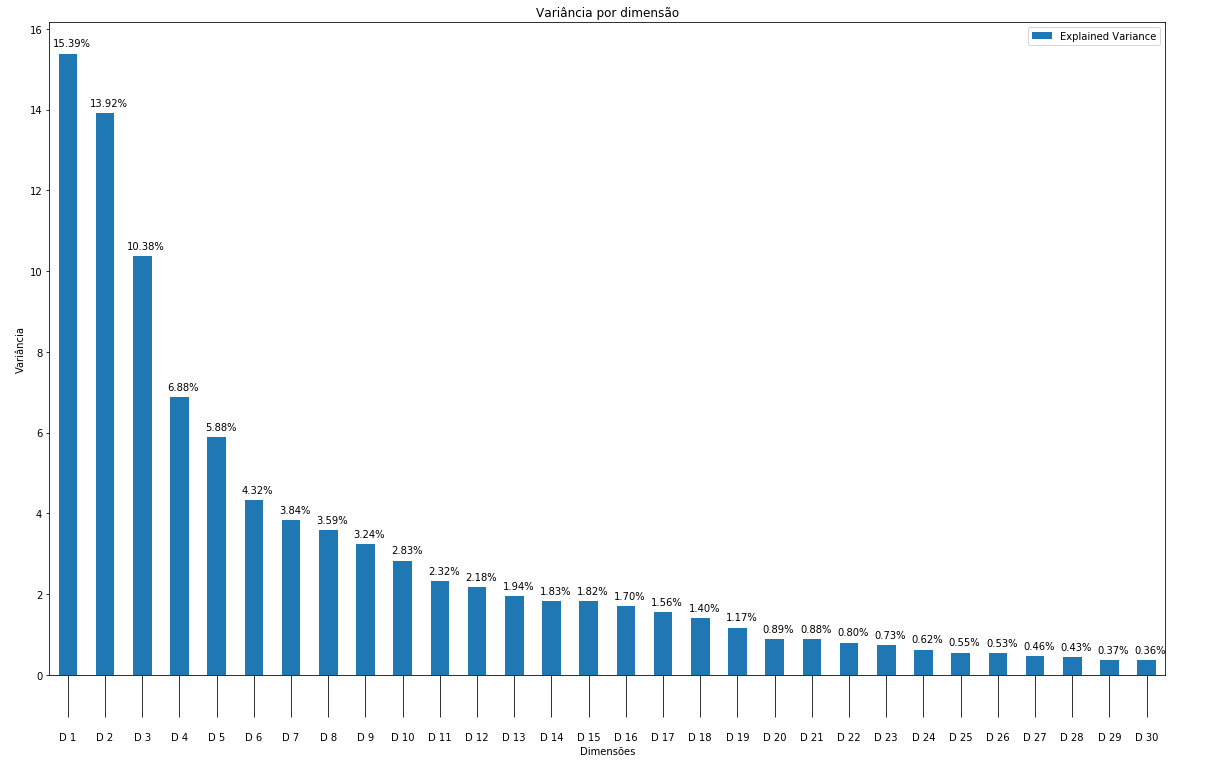

As dimensões juntas apresentam uma variação de 92.81%.


In [258]:
pca = grid.best_estimator_.named_steps['reduce_dim']
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = ['D {}'.format(i) for i in range(1,len(pca.components_)+1)]

# plotando variação das dimensões
(variance_ratios *100).plot(kind="bar", figsize = (20, 12))
ax = plt.gca()
for p in ax.patches:
    ax.annotate("{:.2f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2.,
                                        p.get_height()), ha='center',
                va='center', xytext=(4, 10), textcoords='offset points')
ax.tick_params(axis = 'x', which = 'major', pad = 15, size = 42)
ax.set_ylabel('Variância')
ax.set_xlabel('Dimensões')
plt.title("Variância por dimensão")
plt.setp(ax.get_xticklabels(), rotation = 0)
plt.show()

print('As dimensões juntas apresentam uma variação de {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_) * 100))

### Visualizando as features em cada dimensão

In [278]:
dfPCA = pd.DataFrame(pca.components_,columns=x_train.columns)
dfPCA

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,-0.135170,-0.048854,0.018958,-0.006573,0.017230,0.174755,-0.301729,-0.017286,-0.138939,-0.093668,...,-0.002948,-0.000048,-0.000964,-0.000342,-0.001497,0.000014,0.077799,0.006077,-0.000465,-0.005612
1,0.005445,0.175892,0.343661,0.302625,0.323245,0.086508,0.038325,-0.038861,0.025579,0.017151,...,0.000531,0.000049,0.000270,-0.000127,0.001290,0.000405,-0.027128,0.013090,-0.000247,-0.012843
2,0.084657,0.093563,-0.116474,-0.064554,-0.108006,0.341490,0.179096,0.009807,0.078693,0.055017,...,0.000785,0.000070,0.000605,0.000238,0.001782,-0.000054,-0.051660,0.006031,-0.000717,-0.005314
3,0.198506,-0.390319,0.044249,0.007076,0.039828,0.088923,0.072201,-0.008604,0.051149,0.001052,...,0.001690,-0.000073,-0.000078,-0.000387,-0.001076,-0.000141,-0.013033,-0.036546,-0.000073,0.036619
4,-0.008022,-0.007550,0.000760,-0.006151,-0.000215,-0.000778,0.005170,0.001708,-0.011691,0.004860,...,0.000081,0.000025,-0.000070,-0.000035,0.000673,0.000011,-0.003010,0.014467,0.001071,-0.015538
5,0.308488,0.172265,0.000648,0.055036,0.011536,-0.047193,-0.110362,-0.464208,-0.043602,-0.150266,...,-0.000729,-0.000022,0.001790,-0.000044,0.000732,0.000953,-0.030061,0.010953,-0.000091,-0.010862
6,0.001392,0.025081,0.003676,-0.007005,0.004031,0.000815,-0.012356,0.053578,0.034141,-0.007402,...,-0.000018,-0.000012,0.000034,0.000119,-0.000312,-0.000450,0.010769,-0.009604,0.000074,0.009529
7,-0.267236,-0.153941,-0.024549,-0.090512,-0.029470,0.027929,0.107123,-0.382892,-0.340367,0.104817,...,0.002105,0.000041,0.000835,-0.000684,-0.000374,0.000973,-0.070568,0.019755,0.000270,-0.020025
8,0.196355,0.069117,0.019137,0.025507,0.021870,-0.004966,0.047989,0.297381,-0.571671,-0.041210,...,-0.000325,-0.000077,-0.000466,0.000379,0.000788,-0.000723,0.012837,0.033534,0.000339,-0.033874
9,-0.101313,0.003727,-0.135676,0.402371,-0.093962,-0.005022,0.001873,0.029852,-0.045410,0.051542,...,0.001856,0.000017,-0.000266,0.000479,0.000963,-0.000069,-0.013695,-0.004867,0.000334,0.004533


In [260]:
top_n = 3
#Obtendo o nome das 3 features com maior variância nas 2 primeiras dimensões
dfPCA = dfPCA[:2]
a = pd.DataFrame({n: dfPCA.T[col].nlargest(top_n).index.tolist() 
                  for n, col in enumerate(dfPCA.T)}).T
#Obtendo o nome das 3 features com menor variância nas 2 primeiras dimensões
dfPCA = dfPCA[:2]
b = pd.DataFrame({n: dfPCA.T[col].nsmallest(top_n).index.tolist() 
                  for n, col in enumerate(dfPCA.T)}).T
#criando um dataframe com o nome das features selecionadas
c = a.join(b, how='outer', lsuffix='maiores', rsuffix='menores')
c

,0maiores,1maiores,2maiores,0menores,1menores,2menores
0,AMT_CREDIT_POLY^2 AMT_INCOME_TOTAL_POLY,AMT_CREDIT_POLY^2,AGE,DAYS_BIRTH,AMT_CREDIT_POLY,AMT_CREDIT_POLY^3
1,AMT_CREDIT_LOG,AMT_CREDIT,AMT_CREDIT_PER_AGE,AMT_CREDIT_POLY AMT_INCOME_TOTAL_POLY^2,AMT_CREDIT_POLY AMT_INCOME_TOTAL_POLY,AMT_CREDIT_POLY^2


### Visualizando o peso das features mais influentes por dimensão

Para tentar entender o que cada feature representa na construção de cada dimensão, separei dentro das 2 primeiras dimensões as 3 features que apresentam as maiores e menores variações;

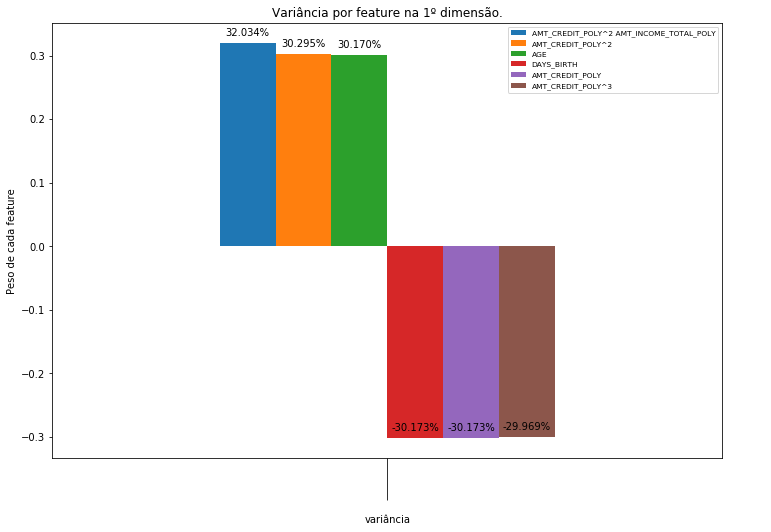

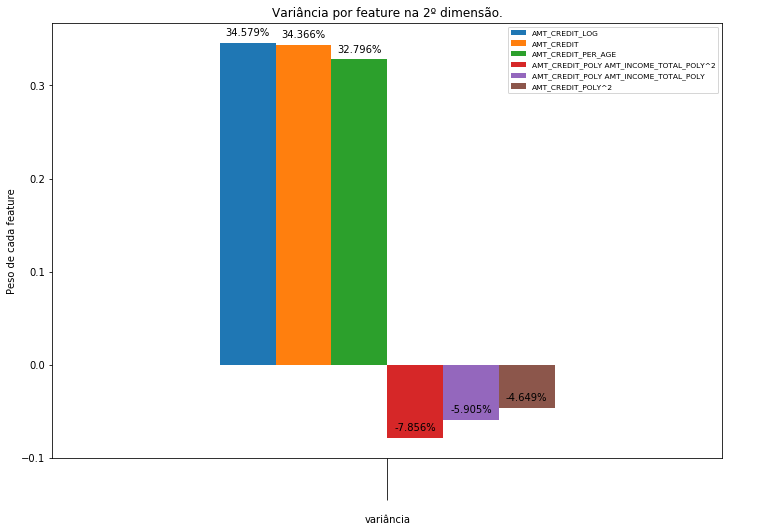

In [261]:
for i in range(2):
    scores_features = pd.DataFrame({'features' : dfPCA[c.iloc[i]].columns, 'variância' : dfPCA[c.iloc[i]].iloc[i]}).set_index('features').T
    scores_features.plot(kind="bar", figsize = (12, 8))
    plt.legend(loc='upper right', prop={'size': 7.5})
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate("{:.3f}%".format(np.round(p.get_height()*100, 4),5), (p.get_x() + p.get_width() / 2.,
                                              p.get_height()), ha='center',
                    va='center', xytext=(0, 10), textcoords='offset points')
    ax.tick_params(axis = 'x', which = 'major', pad = 15, size = 42)
    ax.set_title('Variância por feature')
    ax.set_ylabel('Peso de cada feature')
    plt.title("Variância por feature na {}º dimensão.".format(i+1))
    plt.setp(ax.get_xticklabels(), rotation = 0)
    plt.show()

Eu já esperava encontrar algumas features como: algumas das EXT_SOURCE(2 e 3) e DAYS_BIRTH, devido a correlação que achamos na análise exploratória, mas das features mais correlacionadas, somente a referente a idade que ficou entre as com maior peso. Podemos perceber que a engenharia de features surtil efeito, porque quase todas as features, com exceção de DAYS_BIRTH, ficaram entre as features com maior peso dentro das 2 dimensões com maior variação.

### Visualizando os Resultados

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished


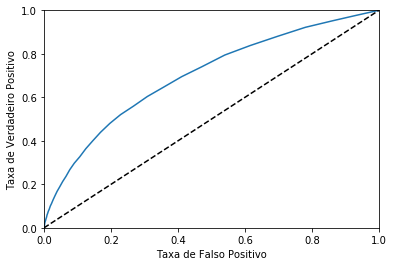

Score Roc: 70.0%


In [282]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_probas = grid.best_estimator_.predict_proba(x_test)
y_scores = y_probas[:, 1] 

fpr1, tpr1, thresholds = roc_curve(y_test, y_scores)

plt.plot(fpr1, tpr1, linewidth=1.5, label=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.show()

print("Score Roc: {}%".format(np.round(roc_auc_score(y_test, y_scores)*100), 2))

Após a engenharia de features, consegui elevar o score de 63 para 70%, isso já um grande avanço, sem contar que me limitei a trabalhar com somente 1 fonte de dados, das 7 fornecidas pela Home Credit, e não utilizei outros modelos para classificar o conjunto de dados.

### Salvando datasets moficados

In [16]:
data_attr_combinados_test['SK_ID_CURR'] = test_ids
data_attr_combinados_train['SK_ID_CURR'] = train_ids
data_attr_combinados_train['TARGET'] = train_labels
data_attr_combinados_test.to_csv("data/application_test_new.csv", sep=',', encoding='utf-8')   
data_attr_combinados_train.to_csv("data/application_train_new.csv", sep=',', encoding='utf-8') 

### Salvando classificador do PCA

In [252]:
with open('classifier_pca.pkl', "wb") as clf_outfile:
    pickle.dump(grid, clf_outfile)

### Carregando classificador

In [253]:
with open('classifier_pca.pkl', "rb") as clf_infile:
    clf = pickle.load(clf_infile)

In [14]:
del data_attr_combinados 
gc.collect()

26

In [25]:
teste = pd.read_csv("data/application_test_new.csv")
teste.head()

,Unnamed: 0,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,SK_ID_CURR
0,0,-0.577538,0.142129,-0.478095,-0.166142,-0.507236,-0.149452,1.506880,-0.456215,0.379837,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100002
1,1,-0.577538,0.426792,1.725450,0.592684,1.600873,-1.252750,-0.166821,-0.460115,1.078697,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100003
2,2,-0.577538,-0.427196,-1.152888,-1.404668,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100004
3,3,-0.577538,-0.142533,-0.711430,0.177875,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100006
4,4,-0.577538,-0.199466,-0.213734,-0.361748,-0.068554,0.563570,-0.892535,-0.473210,0.191639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100007


In [39]:
#teste = teste.drop(columns = ['Unnamed: 0'])
teste.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,SK_ID_CURR
0,-0.577538,0.142129,-0.478095,-0.166142,-0.507236,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100002
1,-0.577538,0.426792,1.725450,0.592684,1.600873,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100003
2,-0.577538,-0.427196,-1.152888,-1.404668,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100004
3,-0.577538,-0.142533,-0.711430,0.177875,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100006
4,-0.577538,-0.199466,-0.213734,-0.361748,-0.068554,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100007
